# W266 Final Project
This notebook contains some EDA and creates the baseline LSTM classifier

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import ast
import os
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding,GlobalMaxPooling1D, concatenate,LSTM,Reshape

In [4]:
#If you want to use TPU

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))
# strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = "/content/drive/MyDrive/w266/cleaned_data.csv"
data = pd.read_csv(path)
glove_path = "/content/drive/MyDrive/w266/glove.6B.100d.txt"

In [8]:
data['critic_reviews'] = data['critic_reviews'].apply(lambda x:np.array(ast.literal_eval(x)))
data["user_reviews"] = data["user_reviews"].apply(lambda y:np.array(ast.literal_eval(y)))

In [9]:
data.head()

,name,date,platform,score,summary,url,userscore,fullurl,developer,genre,user_reviews,critic_reviews
0,Tony Hawk's Pro Skater 2,"September 20, 2000",PlayStation,98,As most major publishers' development efforts ...,/game/playstation/tony-hawks-pro-skater-2,7.4,https://www.metacritic.com/game/playstation/to...,Neversoft Entertainment,"['Sports', 'Alternative', 'Skateboarding']","[Breath-taking, still replayable to this day. ...",[The best skateboarding game ever and one of t...
1,Tony Hawk's Pro Skater 2,"November 6, 2000",Dreamcast,97,"Hawk's back - with new technology, new pros an...",/game/dreamcast/tony-hawks-pro-skater-2,6.1,https://www.metacritic.com/game/dreamcast/tony...,Treyarch,"['Sports', 'Alternative', 'Skateboarding']",[Now this game was what I remember being the b...,"[There's enough skaters, objectives, levels, a..."
2,Perfect Dark,"May 22, 2000",Nintendo 64,97,Step into the Dark... As Carrington Institute'...,/game/nintendo-64/perfect-dark,8.8,https://www.metacritic.com/game/nintendo-64/pe...,Rare Ltd.,"['Action', 'Shooter', 'First-Person', 'Sci-Fi']",[I bought Perfect Dark the day it was released...,[It's a stunning achievement by any measure an...
3,NFL 2K1,"September 7, 2000",Dreamcast,97,"In the end, NFL 2K1 is a deeper, more refined ...",/game/dreamcast/nfl-2k1,6.4,https://www.metacritic.com/game/dreamcast/nfl-2k1,Visual Concepts,"['Sports', 'Traditional', 'Football', 'Sim']",[This game still holds its own after four year...,[Not only is this the first console game that ...
4,Baldur's Gate II: Shadows of Amn,"September 24, 2000",PC,95,An epic continuation of the story that began i...,/game/pc/baldurs-gate-ii-shadows-of-amn,9.1,https://www.metacritic.com/game/pc/baldurs-gat...,BioWare,"['Role-Playing', 'PC-style RPG', 'PC-style RPG...",[Quite possibly the best game ever made! A dee...,"[It's not just vast, but flooded with quests a..."


In [10]:
data.isnull().sum()

name                0
date                0
platform            0
score               0
summary           112
url                 0
userscore           0
fullurl             0
developer           0
genre               0
user_reviews        0
critic_reviews      0
dtype: int64

In [11]:
data.shape

(16139, 12)

# Label of Interest

We're interested in seeing if the critic's reviews can be used to predict the difference in critic and user score. Our constructed label then will be `score` - `userscore`

In [12]:
data = data[(data["user_reviews"].map(len) > 0)]

In [13]:
data = data[data["userscore"]!="tbd"]

#we can't do anything about games with no userscore

In [14]:
data['userscore'] = 10*data["userscore"].astype('float')

In [15]:
data.head()

,name,date,platform,score,summary,url,userscore,fullurl,developer,genre,user_reviews,critic_reviews
0,Tony Hawk's Pro Skater 2,"September 20, 2000",PlayStation,98,As most major publishers' development efforts ...,/game/playstation/tony-hawks-pro-skater-2,74.0,https://www.metacritic.com/game/playstation/to...,Neversoft Entertainment,"['Sports', 'Alternative', 'Skateboarding']","[Breath-taking, still replayable to this day. ...",[The best skateboarding game ever and one of t...
1,Tony Hawk's Pro Skater 2,"November 6, 2000",Dreamcast,97,"Hawk's back - with new technology, new pros an...",/game/dreamcast/tony-hawks-pro-skater-2,61.0,https://www.metacritic.com/game/dreamcast/tony...,Treyarch,"['Sports', 'Alternative', 'Skateboarding']",[Now this game was what I remember being the b...,"[There's enough skaters, objectives, levels, a..."
2,Perfect Dark,"May 22, 2000",Nintendo 64,97,Step into the Dark... As Carrington Institute'...,/game/nintendo-64/perfect-dark,88.0,https://www.metacritic.com/game/nintendo-64/pe...,Rare Ltd.,"['Action', 'Shooter', 'First-Person', 'Sci-Fi']",[I bought Perfect Dark the day it was released...,[It's a stunning achievement by any measure an...
3,NFL 2K1,"September 7, 2000",Dreamcast,97,"In the end, NFL 2K1 is a deeper, more refined ...",/game/dreamcast/nfl-2k1,64.0,https://www.metacritic.com/game/dreamcast/nfl-2k1,Visual Concepts,"['Sports', 'Traditional', 'Football', 'Sim']",[This game still holds its own after four year...,[Not only is this the first console game that ...
4,Baldur's Gate II: Shadows of Amn,"September 24, 2000",PC,95,An epic continuation of the story that began i...,/game/pc/baldurs-gate-ii-shadows-of-amn,91.0,https://www.metacritic.com/game/pc/baldurs-gat...,BioWare,"['Role-Playing', 'PC-style RPG', 'PC-style RPG...",[Quite possibly the best game ever made! A dee...,"[It's not just vast, but flooded with quests a..."


In [16]:
data["target"] = (data["score"]-data["userscore"])

In [17]:
data["binary_target"] = data["target"].apply(lambda x: 1 if x>=0 else 0)

In [18]:
data["target"]

0        24.0
1        36.0
2         9.0
3        33.0
4         4.0
         ... 
16134     9.0
16135    17.0
16136   -10.0
16137    -1.0
16138   -45.0
Name: target, Length: 12850, dtype: float64

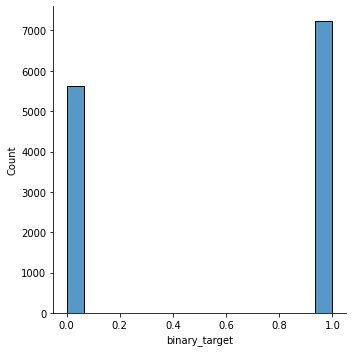

In [19]:
sns.displot(data["binary_target"]);

39.0

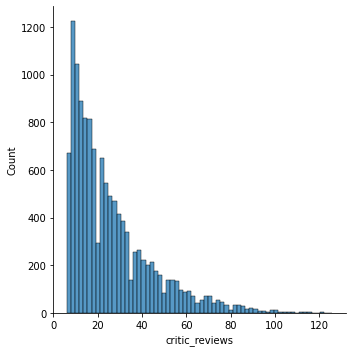

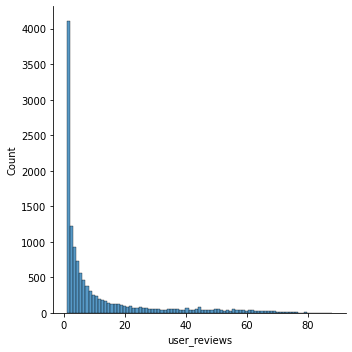

In [20]:
n_critic_reviews = data["critic_reviews"].apply(len)
n_user_reviews =data["user_reviews"].apply(len)
sns.displot(n_critic_reviews)
sns.displot(n_user_reviews)
np.percentile(n_critic_reviews,80)

## Goals:

Random sample 2-7 reviews from each row and concatenate into a single review. keep the score


Vary these parameters: 
embedding
training examples (how many reviews)
architecture (CNN vs RNN vs LSTM vs GRU)



# Shuffle and Split the Data

In [21]:
def create_train_test(df,n_reviews,test_proportion):
    copy = df.copy()
    np.random.seed(0)
    copy["critic_reviews"] = copy["critic_reviews"].apply(lambda x: np.random.choice(x,n_reviews,replace=False) if len(x)>= n_reviews else x)
    copy["critic_reviews"] = copy["critic_reviews"].apply(lambda y: " ".join(y))
    copy["user_reviews"] = (copy["user_reviews"]
                          .apply(lambda x: np.random.choice(x,n_reviews,replace=False) if len(x)>= n_reviews else x))
    copy["user_reviews"] = copy["user_reviews"].apply(lambda y: " ".join(y))
    return train_test_split(copy.drop(columns=["binary_target"]),copy.binary_target,test_size=test_proportion)
    
X_train,X_test,y_train,y_test = create_train_test(data,7,.3)

# Tokenize and prep label

In [22]:
baseline_tokenizer = nltk.RegexpTokenizer(r"\w+")
def prep_text(review_array,t):
    joined = " ".join(review_array)
    tokens = t.tokenize(joined)
    return tokens
    

In [23]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=100)
text_ds = tf.data.Dataset.from_tensor_slices(X_train['critic_reviews']).batch(128)
vectorizer.adapt(text_ds)

In [24]:
vocab = vectorizer.get_vocabulary()

In [25]:
embed_dim=100
embeddings_index = {}
with open(glove_path,encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


### Tokenize

In [26]:
X_train_critic = vectorizer(np.array([[s] for s in X_train["critic_reviews"]]))
X_train_user = vectorizer(np.array([[s] for s in X_train["user_reviews"]]))


X_test_critic = vectorizer(np.array([[s] for s in X_test["critic_reviews"]]))
X_test_user= vectorizer(np.array([[s] for s in X_test["user_reviews"]]))

# Embedding Matrix


In [27]:
embeddings = np.zeros((len(vocab)+2,embed_dim))
for index,word in enumerate(vocab):
    word_embedding = embeddings_index.get(word)
    embeddings[index] = word_embedding

In [28]:
embed_matrix = np.nan_to_num(embeddings)

In [72]:
X_train_critic

<tf.Tensor: shape=(8995, 100), dtype=int64, numpy=
array([[    3,   462,  2162, ...,     9,    31,    72],
       [    3,   643,     5, ...,    10,     8,    81],
       [ 2100,  4322,     7, ...,  5621,   679,    19],
       ...,
       [    2,  1012,   296, ...,  1418, 13186,  4448],
       [   17,     7,     3, ...,     2,   167,   433],
       [    3,   260,   101, ...,    22,   135,     3]])>

# Baseline Model Creation

In [104]:
def create_lstm_baseline():
  vocab_size = vocab
  max_token_len = 100
  kernel_size=3
  dropout_rate = .2
  embed_dim = 100
  rnn_units= 100
  critic_wordids = Input(shape=(max_token_len,),name="critic_wordids")
  critic_embeddings = Embedding(len(vocab)+2, embed_dim, embeddings_initializer = tf.keras.initializers.Constant(embed_matrix),trainable = False)(critic_wordids)

  user_wordids = Input(shape=(max_token_len,),name="user_wordids")
  user_embeddings = Embedding(len(vocab)+2, embed_dim, embeddings_initializer = tf.keras.initializers.Constant(embed_matrix),trainable = False)(user_wordids)

  critic_lstm_output=LSTM(rnn_units,name='Critic_LSTM')(critic_embeddings)
  user_lstm_output =LSTM(rnn_units,name="User_LSTM")(user_embeddings)

  x = concatenate([critic_lstm_output,user_lstm_output])
  x=Flatten()(x)
  dense = Dense(256,activation="relu",name="dense")(x)
  dense = Dense(256,activation="relu",name="dense_3")(dense)
  output = Dense(1, activation='sigmoid',name='output_layer')(dense)
  model = Model(inputs=[critic_wordids,user_wordids], outputs=output)
  model.summary()
  model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryAccuracy('accuracy')])
  return model

In [112]:
lstm_model = create_lstm_baseline()
history_2 = lstm_model.fit([X_train_critic,X_train_user],np.array(y_train),batch_size = 64,epochs = 5)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
critic_wordids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
user_wordids (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, 100, 100)     2000200     critic_wordids[0][0]             
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, 100, 100)     2000200     user_wordids[0][0]               
____________________________________________________________________________________________

In [113]:
results = lstm_model.evaluate([X_test_critic,X_test_user], y_test)
print("test loss, test acc:", results)

121/121 [==============================] - 5s 39ms/step - loss: 0.6828 - accuracy: 0.5673
test loss, test acc: [0.6827648282051086, 0.5673151612281799]


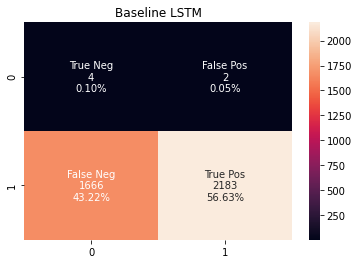

In [114]:
create_confusion_matrix(lstm_model,"Baseline LSTM")

In [43]:
def create_confusion_matrix(model,title):
  y_pred = np.array([np.round(p) for p in model.predict([X_test_critic,X_test_user])]).reshape(-1)
  c = confusion_matrix(y_pred,y_test)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  c.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      c.flatten()/np.sum(c)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(c ,annot=labels,fmt='')
  plt.title(title);
  return plt.show()